<a href="https://colab.research.google.com/github/phaninandula/ERA-Session12/blob/main/ERA1_S12_CIFAR10_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install lightning -q --quiet
# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
!pip install torch-lr-finder -q --quiet
!pip install grad-cam -q --quiet
!pip install --quiet "pandas" "ipython[notebook]" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"

# For inline matplotlib plotting
%matplotlib inline

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [4]:
import os
import torch
from torch import nn, Tensor, optim, utils
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import lightning.pytorch as pl
import torch.nn.functional as F
import torch.nn as nn
import lightning as L
from torchvision import transforms
import torch.utils.data as data
from PIL import Image
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from albumentations import Compose, PadIfNeeded, RandomCrop, Normalize, HorizontalFlip, ShiftScaleRotate, CoarseDropout,Cutout
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np

## Function for setting the seed

In [5]:
L.seed_everything(42)

Global seed set to 42


42

# Loading Datasets

In [6]:
from utils import *
from pl_bolts.datamodules import CIFAR10DataModule

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=album_Compose_train(),
    test_transforms=album_Compose_test(),
    val_transforms=album_Compose_test(),
)

/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature F

# Pytorch Trainer

In [7]:
from models import *

In [8]:
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from models import *

model = Custom_ResNet_for_CIFAR10(lr=0.01, batch_size = BATCH_SIZE)

trainer = Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | Net              | 4.1 M  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.260    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature F

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature F

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature F

Files already downloaded and verified
Files already downloaded and verified


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature F

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3440000116825104     │
│         test_loss         │    2.1114823818206787     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.3440000116825104, 'test_loss': 2.1114823818206787}]

## Misclassified Images - GradCAM

/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature F

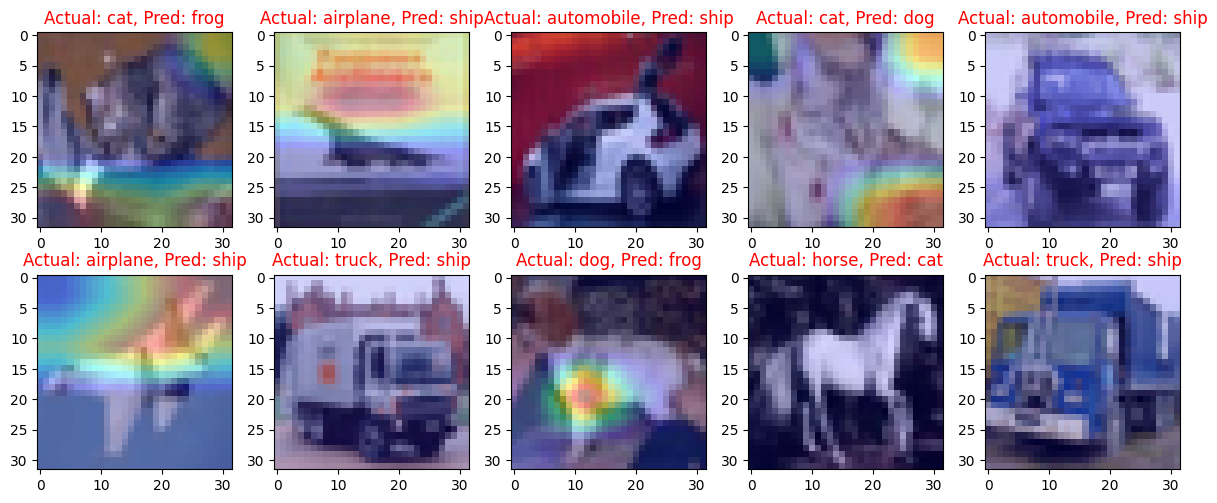

In [9]:
import torch
plot_grad_cam_images_custom_resnet(model.model, cifar10_dm.test_dataloader(), cifar10_dm.dataset_train.dataset.classes, device=torch.device("cpu"))

## Saving the Model

In [10]:
torch.save(model.model.state_dict(), "custom_resnet_model_for_CIFAR10.pt")

## Saving Misclassified images

In [11]:
!mkdir misclassfied_images # Create a new folder for misclassified images

from PIL import Image
import numpy as np

test_loader = cifar10_dm.test_dataloader()
classes =  cifar10_dm.dataset_train.dataset.classes
device = torch.device("cuda")
model1 = model.model.to(device)

# set model to evaluation mode
model1.eval()

misclassified_images = []

fig_idx = 1
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model1(data)
        _, pred = torch.max(output, 1)
        for i in range(len(pred)):
            if pred[i] != target[i]:
                misclassified_images.append(data[i])
                npimg = unnormalize(data[i].cpu())
                im = Image.fromarray((npimg*255).astype(np.uint8))
                im.save(f"./misclassfied_images/Target_{classes[target[i]]}_Pred_{classes[pred[i]]}_{fig_idx}.jpeg")
                if fig_idx > 25: # Saving 25 misclassified images
                    break
                fig_idx+=1


mkdir: misclassfied_images: File exists


AssertionError: Torch not compiled with CUDA enabled

## Zip Misclassified images folder to download

In [2]:
!zip -r ./misclassfied_images.zip ./misclassfied_images/

  adding: misclassfied_images/ (stored 0%)
  adding: misclassfied_images/misclassfied_images/ (stored 0%)
  adding: misclassfied_images/misclassfied_images/Target_frog_Pred_cat_26.jpeg (deflated 17%)
  adding: misclassfied_images/misclassfied_images/Target_ship_Pred_automobile_26.jpeg (deflated 18%)
  adding: misclassfied_images/misclassfied_images/Target_dog_Pred_deer_4.jpeg (deflated 18%)
  adding: misclassfied_images/misclassfied_images/Target_cat_Pred_dog_26.jpeg (deflated 16%)
  adding: misclassfied_images/misclassfied_images/Target_cat_Pred_dog_10.jpeg (deflated 17%)
  adding: misclassfied_images/misclassfied_images/Target_dog_Pred_cat_25.jpeg (deflated 20%)
  adding: misclassfied_images/misclassfied_images/Target_cat_Pred_dog_11.jpeg (deflated 18%)
  adding: misclassfied_images/misclassfied_images/Target_deer_Pred_frog_24.jpeg (deflated 20%)
  adding: misclassfied_images/misclassfied_images/Target_ship_Pred_airplane_26.jpeg (deflated 23%)
  adding: misclassfied_images/misclassfi